# landcover-hack ODC workshop 2019

This is a test notebook to derive a level 3 classification for select areas in Australia based on the FAO LCCS landcover classification

In [1]:
import numpy
import xarray
import scipy
from matplotlib import pyplot
from matplotlib import cm
import datacube
from datacube.storage import masking

#import classification script
import lccs_l3

Data input from AWS DEA

In [173]:
# set up object and bounds

dc = datacube.Datacube(app="le_lccs")

pixel_size_x = -100
pixel_size_y = 100

#current area is Ayr
min_x = 1500000.000
max_x = 1600000.000
min_y = -2200000.000
max_y = -2100000.000

out_crs = "EPSG:3577"

#current area is Townsville
max_lon = 147
min_lon = 146.5
min_lat = -19.5
max_lat = -19

start_time = "2015-01-01"
end_time = "2015-12-15"

## 5 layers required for level 3 classification

- vegetat_veg_cat (layer for vegetation/non vegetation)
- aquatic_wat_cat (layer for aquatic/terrestrial
- cultman_agr_cat (layer for cultivated/natural)
- artific_urb_cat (layer for artificial surfaces/bare areas)
- artwatr_wat_cat (layer for artificial water/natural water)

### vegetat_veg_cat

In [186]:
var_xarray = dc.load(product="fc_percentile_albers_annual", measurements=["PV_PC_50", "NPV_PC_50"],
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(start_time, end_time))

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 1000, y: 1000)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01
  * y          (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.501e+06 ...
Data variables:
    PV_PC_50   (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
    NPV_PC_50  (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
Attributes:
    crs:      EPSG:3577

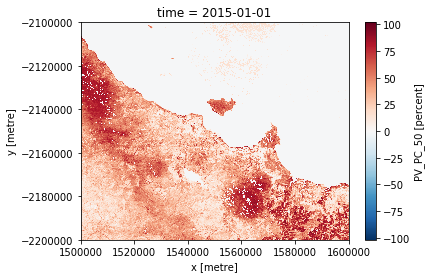

In [187]:
var_xarray.PV_PC_50.plot()

In [178]:
# var_xarray = dc.load(product="fc_percentile_albers_annual",
#                      x=(min_lon, max_lon),
#                      y=(min_lat, max_lat),
#                      output_crs='epsg:3577',
#                      resolution=(pixel_size_x, pixel_size_y),
#                      time=(start_time, end_time))

# # Check that dataset exists
# var_xarray

In [188]:
# Plot data
var_xarray = masking.mask_invalid_data(var_xarray)
var_xarray.PV_PC_10.plot(figsize=(5, 5), cmap = 'Reds')
var_xarray.NPV_PC_10.plot(figsize=(5, 5), cmap = 'Reds')

AttributeError: 'Dataset' object has no attribute 'PV_PC_10'

In [201]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat_veg_cat_ds = ((var_xarray["PV_PC_50"] >= 60) | (var_xarray["NPV_PC_50"] >= 60))

In [202]:
# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat_veg_cat_ds.to_dataset(name="vegetat_veg_cat")

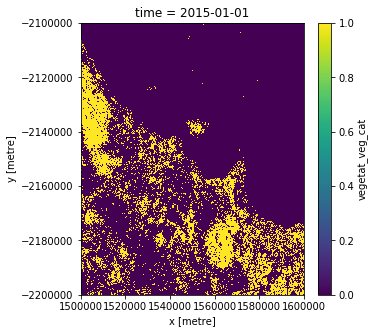

In [203]:
# Plot output
vegetat_veg_cat_ds["vegetat_veg_cat"].plot(figsize=(5, 5))

In [204]:
vegetat_veg_cat_ds = vegetat_veg_cat_ds.squeeze().drop('time')

### aquatic_wat_cat

In [78]:
var_xarray = dc.load(product="wofs_annual_summary",measurements=["frequency"], 
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(start_time, end_time))

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 1000, y: 1000)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01
  * y          (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.501e+06 ...
Data variables:
    frequency  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

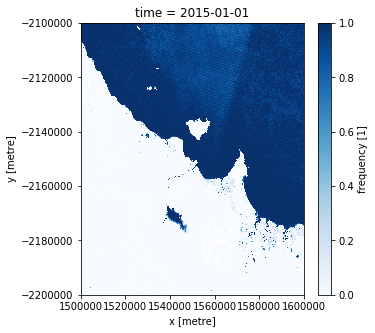

In [79]:
# Plot data
var_xarray = masking.mask_invalid_data(var_xarray)
var_xarray.frequency.plot(figsize=(5, 5), cmap = 'Blues')

In [80]:
# Create binary layer representing aquatic (1) and terrestrial (0)
aquatic_wat_cat_ds = ((var_xarray["frequency"] >= 0.2))

In [81]:
# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat_cat_ds.to_dataset(name="aquatic_wat_cat")

In [120]:
aquatic_wat_cat_ds

<xarray.Dataset>
Dimensions:          (x: 1000, y: 1000)
Coordinates:
  * y                (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x                (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    aquatic_wat_cat  (y, x) bool True True True True True True True True ...

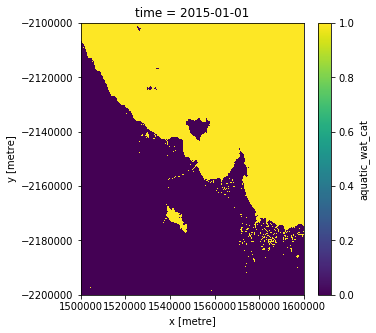

In [82]:
# Plot output
aquatic_wat_cat_ds["aquatic_wat_cat"].plot(figsize=(5, 5))

In [83]:
aquatic_wat_cat_ds = aquatic_wat_cat_ds.squeeze().drop('time')

### cultman_agr_cat

In [135]:
ls8_mads = dc.load(product="ls8_nbart_tmad_annual", x=(min_x, max_x),
                     y=(min_y, max_y),crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(start_time, end_time))

In [136]:
cultman_agr_cat = ((ls8_mads["edev"] > 0.115))

In [137]:
cultman_agr_cat = cultman_agr_cat.to_dataset(name="cultman_agr_cat")

In [141]:
cultman_agr_cat = cultman_agr_cat.squeeze().drop('time')

# alternative secret cultman


In [122]:
# chad_cult = xarray.open_rasterio('/home/jovyan/landcover-hack/cultivated_areas_layer/cultivated_land_01_wofs_townsville_015_201601_201801.tif')

In [123]:
# chad_cult = chad_cult.astype(bool)

In [124]:
# chad_cult = chad_cult.squeeze().drop('band')

In [216]:
# chad_cult.plot()

In [125]:
# cultman_agr_cat = chad_cult.to_dataset(name="cultman_agr_cat")

In [126]:
# variables_xarray_list.append(cultman_agr_cat)

### artific_urb_cat

### artwatr_wat_cat

In [89]:
var_xarray = dc.load(product="geofabric",measurements=["band1"],
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y))

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2014-02-10T18:32:38
  * y        (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.501e+06 ...
Data variables:
    band1    (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

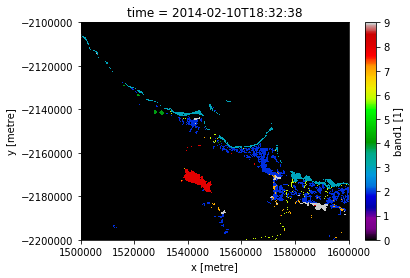

In [90]:
# Plot data
var_xarray.band1.isel(time=0).plot.imshow(cmap="nipy_spectral")

In [91]:
# Create binary layer representing artificial water (1) and natural water (0)
artwatr_wat_cat_ds = ((var_xarray["band1"] == 1) | (var_xarray["band1"] == 8))

In [92]:
# Convert to Dataset and add name
artwatr_wat_cat_ds = artwatr_wat_cat_ds.to_dataset(name="artwatr_wat_cat")

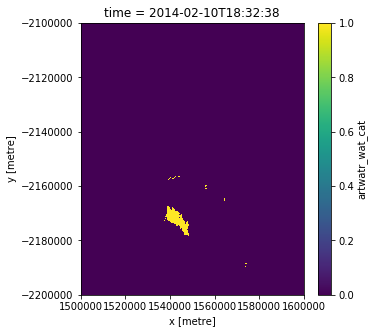

In [93]:
# Plot output
artwatr_wat_cat_ds["artwatr_wat_cat"].plot(figsize=(5, 5))

In [96]:
artwatr_wat_cat_ds = artwatr_wat_cat_ds.squeeze().drop('time')

In [205]:
variables_xarray_list = []
variables_xarray_list.append(artwatr_wat_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(cultman_agr_cat)

## Classification

The LCCS classificaition is hierachial. The 8 classes are shown below.

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [206]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

In [207]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [208]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset({"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
                                   "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
                                   "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])
classification_data

col_level2 = cm.get_cmap("Set1", 2)
# classification_data.level2.plot(cmap=(col_level2))

In [209]:
print("level 1:",numpy.unique(classification_data.level1))
print("level 2:",numpy.unique(classification_data.level2))
print("level 3:",numpy.unique(classification_data.level3))

level 1: [100 200]
level 2: [10 20]
level 3: [  0 111 112 123 124 227 228]


In [214]:
# from cartopy.feature import NaturalEarthFeature
# shp_fn = shpreader.natural_earth(resolution=resolution, category='cultural', name='populated_places')

# states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
#                                  name='admin_1_states_provinces_shp')

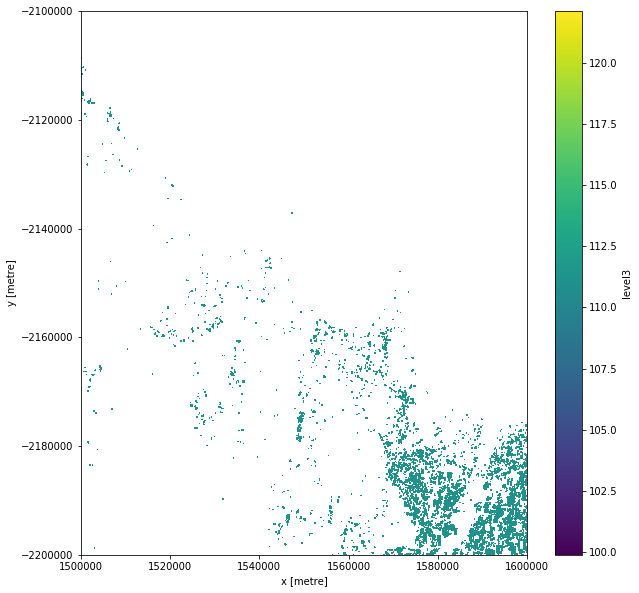

In [212]:
classification_data.level3.where(classification_data.level3 == 111).plot(figsize=(10,10))

In [ ]:
bleh = classification_data.level3.where(classification_data.level3 == 111)#.plot()
bleh=bleh.drop('time').squeeze()
bleh.to_netcdf('test4.nc')

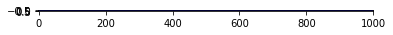

In [215]:
#To check the results for level 3 use colour_lccs_level3 to get the colour scheme.
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3[0])
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))